# 0. Imports and Constants
- Select user before proceeding

In [2]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
from PIL import Image

 ##################################################

############## TASK-SPECIFIC MODULES ##############
sys.path.append("..")
sys.path.append("../..")
from ml.datasets import VanillaDataset
from ml.models import VanillaNN
from ml.trainer import Trainer
from ml.eval import get_output_scores
from data import utils
from analysis.utils import extract_datapoints
###################################################


####################### CONSTANTS ########################
SPLITS = ["train", "dev", "test", "gold"]
TRAIN, DEV, TEST, TXT, IMG = "train", "dev", "test", "txt", "img"
FE_METHODS = ["txt_embeddings", "img_embeddings", "concat", "sum", "mean", "hadamard", "paraphrase"]
TRAIN, DEV, TEST, GOLD = "train", "dev", "test", "gold"
#FE_METHODS += ["concat_cos", "sum_cos", "mean_cos", "hadamard_cos"]
##########################################################

############## DATA SCIENCE & ML MODULES #################
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import classification_report
import pandas as pd
##########################################################

####################### SELECT ###########################
users = ["patriziopalmisano", "onurdenizguler", "jockl"]
user = users[1] # SELECT USER
version = "v2" # SELECT DATASET VERSION
dataset_version = version
##########################################################

if user in users[:2]:
    data_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{version}"
    cw_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive"

else:
    data_dir = f"/home/jockl/Insync/check.worthiness@gmail.com/Google Drive/data/CT23_1A_checkworthy_multimodal_english_{dataset_version}"
    cw_dir = "/home/jockl/Insync/check.worthiness@gmail.com/Google Drive"

features_dir = f"{data_dir}/features"
labels_dir = f"{data_dir}/labels"
models_dir = f"{cw_dir}/models/vanillann_hyperparam_search"
evals_dir = f"{models_dir}/gold_evals"

# 1. Load the Datasets

In [20]:
split_to_labels = {split: 
                        np.load(f"{labels_dir}/{split}_labels_{dataset_version}.pickle", allow_pickle=True) if split != "gold" else 
                        np.load(f"{labels_dir}/{split}_labels.pickle", allow_pickle=True)
                for split in SPLITS}

method_to_split_to_data = {fe_method: {
                                split: 
                                        np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}_{dataset_version}.pickle", allow_pickle=True) if split != "gold" else 
                                        np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}.pickle", allow_pickle=True)
                                for split in SPLITS} 
                        for fe_method in FE_METHODS}

method_to_split_to_dataset = {fe_method: {
                                split:
                                        VanillaDataset(method_to_split_to_data[fe_method][split], split_to_labels[split]) 
                                for split in SPLITS} 
                        for fe_method in FE_METHODS}

In [22]:
# Select our best models

# Set feature method, model name, batch size, hidden dims

models =  {
    # "13-06-2023_01-03_txt_embeddings_32x16_lr_1e-05_batch-size_16_shuffled_f1_0.76":
    #  ("txt_embeddings", [32, 16]),
    #  "13-06-2023_05-33_mean_128x64x32x16_lr_0.001_batch-size_8_shuffled_f1_0.71":
    #  ("mean", [128, 64, 32, 16]),
    #   "13-06-2023_03-03_concat_128x64x32_lr_0.0001_batch-size_64_shuffled_f1_0.75":
    #   ("concat", [128, 64, 32]),
    #  "12-06-2023_23-42_txt_embeddings_128x64x32_lr_0.0001_batch-size_8_shuffled_f1_0.74":
    #  ("txt_embeddings", [128,64,32]),
    #  "12-06-2023_23-43_txt_embeddings_128x64x32_lr_0.0001_batch-size_16_shuffled_f1_0.73":
    #  ("txt_embeddings", [128,64,32]),
    #  "13-06-2023_00-21_txt_embeddings_128x64_lr_1e-06_batch-size_8_shuffled_f1_0.75":
    #  ("txt_embeddings", [128,64]),
    #  "13-06-2023_06-54_mean_64x32_lr_0.001_batch-size_8_shuffled_f1_0.69":
    #  ("mean", [64, 32]),
    #  "13-06-2023_05-44_mean_128x64x32_lr_1e-06_batch-size_8_shuffled_f1_0.67":
    #  ("mean", [128, 64, 32]),
    #  "12-06-2023_23-05_txt_embeddings_128x64x32x16_lr_1e-06_batch-size_8_shuffled_f1_0.74":
    #  ("txt_embeddings", [128,64,32, 16]),
    #  "12-06-2023_23-16_txt_embeddings_128x64x32x16_lr_0.0001_batch-size_128_shuffled_f1_0.73":
    #  ("txt_embeddings", [128,64,32, 16]),
    #  "13-06-2023_00-27_txt_embeddings_128x64_lr_1e-05_batch-size_32_shuffled_f1_0.74":
    #  ("txt_embeddings", [128,64]),
    #  "13-06-2023_05-32_mean_128x64x32x16_lr_0.0001_batch-size_16_shuffled_f1_0.69":
    #  ("mean", [128, 64, 32, 16]),
    #  "13-06-2023_05-52_mean_128x64x32_lr_0.001_batch-size_32_shuffled_f1_0.71":
    #  ("mean", [128, 64, 32]),
    #   "13-06-2023_06-14_mean_64x32x128_lr_0.0001_batch-size_32_shuffled_f1_0.70":
    #   ("mean", [64, 32, 128]),
    #   "13-06-2023_07-10_mean_32x16_lr_1e-05_batch-size_16_shuffled_f1_0.69":
    #   ("mean", [32,16]),
    #   "13-06-2023_02-21_concat_128x64x32x16_lr_1e-05_batch-size_16_shuffled_f1_0.72":
    #   ("concat", [128,64,32,16]),
    #   "13-06-2023_04-46_concat_32x16_lr_0.0001_batch-size_16_shuffled_f1_0.74":
    #   ("concat", [32,16]),
    #   "10-07-2023_22-56_paraphrase_32x16_lr_0.0005_batch-size_32_shuffled_f1_0.70":
    #   ("paraphrase", [32,16]),
    #   "10-07-2023_22-48_paraphrase_32x16_lr_1e-06_batch-size_16_shuffled_f1_0.60":
    #   ("paraphrase", [32, 16]),
    #   "13-06-2023_02-15_concat_128x64x32x16_lr_1e-06_batch-size_16_shuffled_f1_0.72":
    #   ("concat", [128, 64, 32, 16]),
    #   "12-06-2023_23-58_txt_embeddings_64x32x128_lr_1e-06_batch-size_8_shuffled_f1_0.74":
    #   ("txt_embeddings", [64,32,128]),
       "13-06-2023_05-44_mean_128x64x32_lr_1e-06_batch-size_8_shuffled_f1_0.67":
       ("mean", [128, 64, 32]),
}

df_data = {
    "split": [],
    "datapoint_id": [],
    "actual_label": [],
}
for split in SPLITS:
    for model_name, model_properties in models.items():
        feature_method = model_properties[0]
        hidden_dims = model_properties[1]
        shuffle = False
        output_dim = [1]
        batch_size = 16
        dataset = method_to_split_to_dataset[feature_method][split]
        split_size = len(dataset)
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)


        # Instantiate model
        model_dir = f"{models_dir}/{feature_method}/{model_name}.pt"
        input_dim = [len(dataset[0][0])]
        init_params = input_dim + hidden_dims + output_dim
        model = VanillaNN(init_params)
        model.load_state_dict(torch.load(model_dir))
        model.eval()

        output_scores, actual_labels = get_output_scores(model,dataloader)
        if not model_name in df_data.keys():
            df_data[model_name] = output_scores
        else:
            df_data[model_name].extend(output_scores)
    df_data["split"].extend([split]*split_size)
    df_data["datapoint_id"].extend(list(range(0,split_size)))
    df_data["actual_label"].extend(actual_labels)

In [75]:

#df["mean_model_score"] = df["mean_model_score"].apply(lambda x: round(x, 2))
# for model_key in model_output_column_keys:
#     df[model_key] = df[model_key].apply(lambda x: round(x, 2) )

(0.0, 100.0)

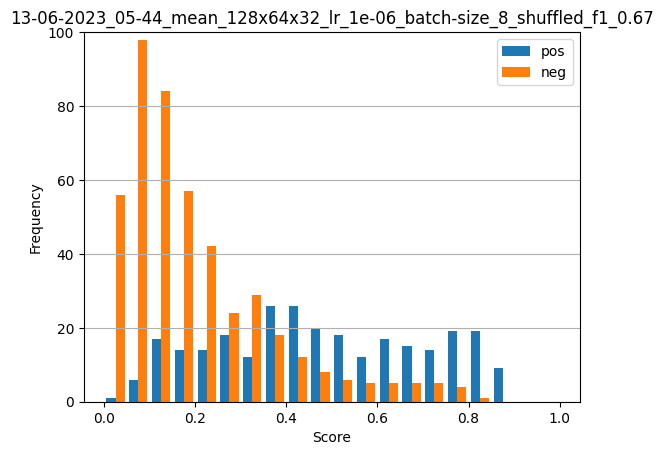

In [29]:
df = pd.DataFrame(df_data)
model_output_column_keys = df.columns[3:]
df["mean_model_score"] = df.iloc[:, 3:].mean(axis=1)

df_focus = df[(df["split"] == "gold") | (df["split"] == "gold" )]
selected_column = 3
scores_pos_class = df_focus[df_focus["actual_label"]==1.0].iloc[:,selected_column].to_list()
scores_neg_class = df_focus[df_focus["actual_label"]==0.0].iloc[:,selected_column].to_list()
model_name = str(df_focus.columns[selected_column])
bins = [x/100 for x in range(0,105, 5)]
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist([scores_pos_class, scores_neg_class], bins=bins, label=['pos', 'neg'])
                            #alpha=0.7, rwidth=0.85)
plt.grid(axis='y')#, alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(model_name)
plt.legend(loc='upper right')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [10]:
dataset_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english"
raw_dataset, texts, imgs, tweet_ids = utils.load_data_splits_with_gold_dataset(dataset_dir,version)

right_edge_negatives = df_focus[(df_focus["actual_label"]==0.0) & (df_focus.iloc[:,4]>=0.80)][:25]
left_edge_negatives = df_focus[(df_focus["actual_label"]==0.0) & (df_focus.iloc[:,4]<=0.10)][:25]
right_edge_positives = df_focus[(df_focus["actual_label"]==1.0) & (df_focus.iloc[:,4]>=0.80)][:25]
left_edge_positives = df_focus[(df_focus["actual_label"]==1.0) & (df_focus.iloc[:,4]<=0.10)][:25]

model_prediction_dict = {
    1: 1,
    2: 0,
    3: 1,
    4: 0,
}



Sizes of train/test/dev/gold txt and img arrays respectively: 
2356 2356
271 271
548 548
736 736


In [68]:
labelling_df = pd.DataFrame(df_data)
labelling_df_randomized = labelling_df.iloc[np.random.permutation(list(range(len(labelling_df)))),:]
labelling_df_randomized.to_excel("labelling_datapoints_randomized.xlsx")

In [6]:
raw_dataset["gold"][0]

{'tweet_id': '1196687191747039232',
 'tweet_url': 'https://twitter.com/user/status/1196687191747039232',
 'tweet_text': 'Got my first paying job(digital marketing) 💃🏽 please follow me on IG guys 🙏👏🏽. https://t.co/v6N1kJ24Sb',
 'ocr_text': '',
 'image_path': 'images_labeled/test/1196687191747039232.jpg',
 'image_url': 'http://pbs.twimg.com/ext_tw_video_thumb/1196687124055109635/pu/img/oYYUUZUaKOAGVOWZ.jpg',
 'class_label': 'No'}

# Find datapoints switching sides moving from concat embeddings to mean

In [12]:
twilight_high = 0.7
twilight_low= 0.3
df_focus.loc[:, "prediction_mean"] = df_focus.iloc[:,3].apply(lambda x: 1 if x>=0.5 else 0)
df_focus.loc[:, "is_twilight_mean"]  = df_focus.iloc[:,3].apply(lambda x: True if twilight_high>=x>=twilight_low else False)
df_focus.loc[:, "prediction_concat"] = df_focus.iloc[:,4].apply(lambda x: 1 if x>=0.5 else 0)
df_focus.loc[:, "is_twilight_concat"]  = df_focus.iloc[:,4].apply(lambda x: True if twilight_high>=x>=twilight_low else False)
df_focus.loc[:, "shift"] = df_focus.iloc[:,3] - df_focus.iloc[:, 4]
df_focus.loc[:, "switched"] = df_focus["prediction_mean"] != df_focus["prediction_concat"]
df_focus.loc[:, "saved_from_twilight"] = df_focus["is_twilight_concat"] & ~df_focus["is_twilight_mean"] & (df_focus["prediction_mean"] == df_focus["actual_label"])
df_focus.loc[:, "made_worse"] = ~df_focus["is_twilight_concat"] & (df_focus["is_twilight_mean"] | ((df_focus["prediction_concat"] == df_focus["actual_label"]) & (df_focus["prediction_mean"] != df_focus["actual_label"])))

In [19]:
classes = {"0": {}, "1": {}}
for _class, _dict in classes.items():
    _dict["num_made_worse"] = len(df_focus[(df_focus["made_worse"] == True) & (df_focus["actual_label"] == float(_class))])
    _dict["num_saved_from_twilight"] = len(df_focus[(df_focus["saved_from_twilight"] == True) & (df_focus["actual_label"] == float(_class))])
pd.DataFrame(classes).transpose()

,num_made_worse,num_saved_from_twilight
0,70,16
1,13,39


In [31]:
made_worse_negatives = df_focus[(df_focus["actual_label"]==0.0) & (df_focus["made_worse"])]
saved_from_twilight_negatives = df_focus[(df_focus["actual_label"]==0.0) & (df_focus["saved_from_twilight"])]
made_worse_positives = df_focus[(df_focus["actual_label"]==1.0) & (df_focus["made_worse"])]
saved_from_twilight_positives = df_focus[(df_focus["actual_label"]==1.0) & (df_focus["saved_from_twilight"])]

df_dict = {
    "made_worse_negatives": made_worse_negatives, 
    "saved_from_twilight_negatives": saved_from_twilight_negatives, 
    "made_worse_positives": made_worse_positives,
    "saved_from_twilight_positives": saved_from_twilight_positives}

In [33]:
result = extract_datapoints(df_dict, raw_dataset, texts, tweet_ids)

In [34]:
result.to_excel("results.xlsx")

In [31]:
TP = len(df_focus[(df_focus.actual_label == 1) & (df_focus.results_from_best_mean == 1)])
FP = len(df_focus[(df_focus.actual_label == 0) & (df_focus.results_from_best_mean == 1)])
FN = len(df_focus[(df_focus.actual_label == 1) & (df_focus.results_from_best_mean == 0)])
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*(precision*recall)/(precision+recall)
print(f1)

0.7324955116696589


In [29]:
df_focus["results_from_best_mean"] =  df_focus.iloc[:,13].apply(lambda x: 1 if x > 0.33 else 0)

/var/folders/01/g3_km85s2szfllv46j0d2vvw0000gn/T/ipykernel_37075/2023374813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["results_from_best_mean"] =  df_focus.iloc[:,13].apply(lambda x: 1 if x > 0.33 else 0)


In [36]:
confidence = df_focus["raw_confidence"].to_list()

In [34]:
thresh = 0.33
df_focus["raw_confidence"] = df_focus["mean_model_score"].apply(lambda x: 100*(x-0.33)/0.67 if x>=0.33 else 100*(0.33-x)/0.33)

/var/folders/01/g3_km85s2szfllv46j0d2vvw0000gn/T/ipykernel_30634/837840015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["raw_confidence"] = df_focus["mean_model_score"].apply(lambda x: 100*(x-0.33)/0.67 if x>=0.33 else 100*(0.33-x)/0.33)


In [38]:
import pickle
with open("confidence_gold.pickle", 'wb') as handle:
    pickle.dump(confidence, handle, protocol=pickle.HIGHEST_PROTOCOL)